### Imports  
*All the Python imports go here.*

In [1]:
import os, re, math, time, glob
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import decomposition
from TextProcessor import *
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2019)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/mdleiton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


## Read data

## Training and Test 

In [3]:
df_model_training = pd.read_csv('../data/training.csv')
df_model_test = pd.read_csv('../data/test.csv')

In [4]:
df_model_training.category.value_counts(normalize=True)

polit       0.203806
health      0.185390
crime       0.170657
economi     0.169429
educ        0.132597
unemploy    0.082873
corrupt     0.055249
Name: category, dtype: float64

In [5]:
df_model_test.category.value_counts(normalize=True)

polit       0.217454
health      0.187411
economi     0.161660
crime       0.153076
educ        0.138770
unemploy    0.084406
corrupt     0.057225
Name: category, dtype: float64

# Prediction

Using the training and test dataset, we will predict the category of news.

### SVM Classifier

In [6]:
frames = [df_model_training, df_model_test]
df_model = pd.concat(frames)

In [7]:
# Create TFIDF matrix.
corpus = df_model['tokens-headline-stopwords-stemming']
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(corpus)
print(matrix.shape)

(2328, 4166)


In [8]:
# Split my data on training y test.
num_training = len(df_model_training)
X_train = matrix[:num_training,:]
X_test = matrix[num_training:,:]
y_train = df_model["category"].values[:num_training]
y_test = df_model['category'].values[num_training:]

In [9]:
# Create the SVM classifier
clf = SVC(probability=True, kernel='linear')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [10]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))
display()

              precision    recall  f1-score   support

     corrupt       1.00      0.23      0.37        40
       crime       0.82      0.84      0.83       107
     economi       0.86      0.81      0.84       113
        educ       0.98      0.82      0.89        97
      health       0.80      0.87      0.83       131
       polit       0.62      0.82      0.71       152
    unemploy       0.98      0.80      0.88        59

    accuracy                           0.80       699
   macro avg       0.86      0.74      0.76       699
weighted avg       0.82      0.80      0.79       699



### Any Traditional ML Classifier

### Any Neural Network Classifier

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
import plotly.graph_objs as go
import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from keras.utils import plot_model

In [122]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 600
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 15
# This is fixed.
EMBEDDING_DIM = 20

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(corpus.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4165 unique tokens.


In [123]:
X = tokenizer.texts_to_sequences(corpus.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2328, 15)


In [124]:
Y = pd.get_dummies(df_model['category'])
target_labels = Y.columns
target = Y.as_matrix()
Y = target.copy()
print('Shape of label tensor:', target.shape)

Shape of label tensor: (2328, 7)


In [125]:
X_train = X[:num_training,:]
X_test = X[num_training:,:]
y_train = Y[:num_training]
y_test = Y[num_training:]

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1629, 15) (1629, 7)
(699, 15) (699, 7)


In [146]:
model = Sequential(name='ALG_1')
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1], name='Embedding'))
model.add(SpatialDropout1D(0.2, name='SpatialDropout1D'))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, name='LSTM'))
model.add(Dense(7, activation='softmax', name='Dense_softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(model, to_file='LSTM.png',show_shapes=True, show_layer_names=True)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 15, 20)            12000     
_________________________________________________________________
SpatialDropout1D (SpatialDro (None, 15, 20)            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 100)               48400     
_________________________________________________________________
Dense_softmax (Dense)        (None, 7)                 707       
Total params: 61,107
Trainable params: 61,107
Non-trainable params: 0
_________________________________________________________________
None


In [149]:
epochs = 10
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 1303 samples, validate on 326 samples
Epoch 1/10
1303/1303 [==============================] - 0s 240us/step - loss: 0.6007 - acc: 0.8204 - val_loss: 0.7467 - val_acc: 0.7791
Epoch 2/10
1303/1303 [==============================] - 0s 211us/step - loss: 0.5688 - acc: 0.8166 - val_loss: 0.7794 - val_acc: 0.7669
Epoch 3/10
1303/1303 [==============================] - 0s 221us/step - loss: 0.5005 - acc: 0.8450 - val_loss: 0.7462 - val_acc: 0.7669
Epoch 4/10
1303/1303 [==============================] - 0s 232us/step - loss: 0.4510 - acc: 0.8611 - val_loss: 0.7542 - val_acc: 0.7515
Epoch 5/10
1303/1303 [==============================] - 0s 213us/step - loss: 0.4138 - acc: 0.8757 - val_loss: 0.7372 - val_acc: 0.7577
Epoch 6/10
1303/1303 [==============================] - 0s 218us/step - loss: 0.3991 - acc: 0.8741 - val_loss: 0.7512 - val_acc: 0.7699
Epoch 7/10
1303/1303 [==============================] - 0s 279us/step - loss: 0.3597 - acc: 0.8833 - val_loss: 0.7812 - val_acc: 0.7607
E

In [150]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

699/699 [==============================] - 0s 144us/step
Test set
  Loss: 0.750
  Accuracy: 0.778


In [151]:
import matplotlib.pyplot as plt

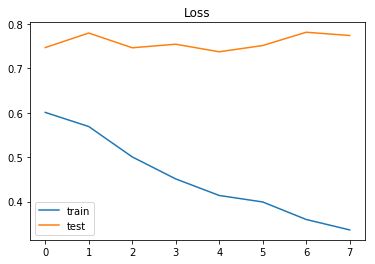

In [152]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

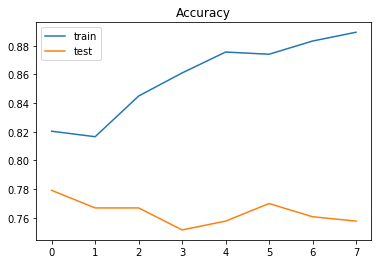

In [153]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();